In [1]:
#KHAI BÁO THƯ VIỆN
import torch
import torchvision
from torchvision import models,transforms
import os.path as osp
import glob
import torch.utils.data as data
from PIL import Image 
import numpy as np
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [18]:
# ĐỊNH DẠNH ẢNH ĐẦU VÀO
class ImageTransform():
  def __init__(self, resize,mean,std):
    self.data_transform = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(resize,scale=(0.5,1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean,std)
        ]),

        'val':transforms.Compose([
            transforms.Resize(resize),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean,std)
        ]),
        'test':transforms.Compose([
            transforms.Resize(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean,std)
        ]),
    }
  def __call__(self,img,phase = 'train'):
    return self.data_transform[phase](img)


In [19]:
#LẤY VÀ ĐƯA CÁC ẢNH VÀO LIST
def make_data_list(phase):
  train_path = osp.join("datasets/" + phase +  "/*/*.jpg")
  path_list = []
  for path in glob.glob(train_path):
    path_list.append(path)
  return path_list

In [20]:
train_list = make_data_list('train')
val_list = make_data_list('val')
test_list = make_data_list('test')
print(len(train_list))
print(len(val_list))
print(len(test_list))

3913
1730
150


In [21]:
#GÁN NHÁN CHO CÁC ẢNH TRONG LIST TRÊN
class MyDataset(data.Dataset):
  def __init__(self,file_list,transform=None,phase="train"):
    self.file_list = file_list
    self.transform = transform
    self.phase = phase

  def __len__(self):
    return len(self.file_list)
  
  def __getitem__(self,id):
    img_path = self.file_list[id]
    img = Image.open(img_path)

    img_tranformed = self.transform(img,self.phase)

    if self.phase == "train":
      label = img_path[15:19]
    elif self.phase == "val":
      label = img_path[13:17]
    if label == "free":
      label = 0
    elif label == "busy":
      label = 1
    return img_tranformed,label

In [22]:
resize = (224,224)
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_dataset = MyDataset(train_list,ImageTransform(resize,mean,std),phase = 'train')
val_dataset = MyDataset(val_list,ImageTransform(resize,mean,std),phase='val')

In [23]:
img, label = train_dataset.__getitem__(0)
print(img.shape,label)

torch.Size([3, 224, 224]) 1


In [24]:
#SET SỐ LƯỢNG ẢNH MỖI LẦN ĐƯA VÀO
batch_size = 10
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size,shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size,shuffle=True)

In [25]:
dataload_dict = {"train":train_dataloader,"val":val_dataloader}
batch_iter= iter(dataload_dict["val"])
inputs , labels = next(batch_iter)

In [26]:
print(inputs.shape)
print(labels)

torch.Size([10, 3, 224, 224])
tensor([0, 1, 1, 1, 1, 0, 0, 0, 1, 0])


In [27]:
#TẠO MODEL
class Cnn(nn.Module):
  def __init__(self):
    super(Cnn,self).__init__()
    self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
    self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
    self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
    self.fc1 = nn.Linear(3*3*64,10)
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(10,2)
    self.relu = nn.ReLU()
        
  def forward(self,x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = self.layer3(out)
      out = out.view(out.size(0),-1)
      out = self.relu(self.fc1(out))
      out = self.fc2(out)
      return out

In [28]:
model = Cnn()
print(model)

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [29]:
input_images = torch.rand(1,3,224,224)
print(input_images)
output = model(input_images)
print(output)

tensor([[[[0.9020, 0.6165, 0.0093,  ..., 0.9397, 0.1204, 0.9190],
          [0.8863, 0.7210, 0.4037,  ..., 0.9882, 0.2217, 0.1206],
          [0.5004, 0.1145, 0.0571,  ..., 0.5877, 0.0384, 0.5664],
          ...,
          [0.9784, 0.1555, 0.9299,  ..., 0.9877, 0.6203, 0.0691],
          [0.2193, 0.6373, 0.7945,  ..., 0.5937, 0.7134, 0.8317],
          [0.5305, 0.6797, 0.5843,  ..., 0.3846, 0.6541, 0.8882]],

         [[0.9461, 0.3719, 0.1634,  ..., 0.4795, 0.4996, 0.9270],
          [0.2536, 0.4508, 0.6622,  ..., 0.4695, 0.5848, 0.4850],
          [0.3356, 0.2719, 0.8030,  ..., 0.2782, 0.3555, 0.0523],
          ...,
          [0.1497, 0.5933, 0.9242,  ..., 0.2234, 0.7241, 0.0632],
          [0.6792, 0.8187, 0.4896,  ..., 0.0846, 0.7917, 0.3494],
          [0.5422, 0.6504, 0.8500,  ..., 0.6656, 0.5624, 0.1682]],

         [[0.8935, 0.1235, 0.4321,  ..., 0.6511, 0.3902, 0.0496],
          [0.7923, 0.5986, 0.3715,  ..., 0.1024, 0.6982, 0.0892],
          [0.2436, 0.0604, 0.2076,  ..., 0

In [30]:
# XÂY DỰNG HÀM TRAIN MODEL 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
save_path = 'model.pth'

In [31]:
def train_model(model,dataloader_dict,criterion, optimizer,num_epochs):
  train_losses, valid_losses = [], []
  for epoch in range(num_epochs):
    print("Epoch{}-{}".format( epoch, num_epochs))

    for phase in ["train" ,"val" ]:
      if phase =="train":
        model.train()
      else:
        model.eval()
      epoch_loss=0.0
      epoch_corrects=0

      if(epoch==0) and (phase=="train"):
        continue
      for inputs,labels in tqdm(dataloader_dict[phase]):
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=="train"):
          outputs=model(inputs)
          loss = criterion(outputs,labels)
          _,preds=torch.max(outputs,1)
          if phase =="train":
            loss.backward()
            optimizer.step()

          epoch_loss += loss.item()*inputs.size(0)
          epoch_corrects += torch.sum(preds == labels.data)

      epoch_loss = epoch_loss/ len(dataloader_dict[phase].dataset)
      epoch_accuracy = epoch_corrects.double()/ len(dataloader_dict[phase].dataset)
      train_losses.append(epoch_loss)
      valid_losses.append(epoch_accuracy)

      print("{} Loss:{:.4f} Acc: {:.4f}".format(phase,epoch_loss,epoch_accuracy))
  torch.save(model.state_dict(), save_path)
  return train_losses,valid_losses    

In [ ]:
# BẮT ĐẦU TRAIN
num_epoch = 10
train_losses,valid_losses = train_model(model,dataload_dict,criterion,optimizer,num_epoch)

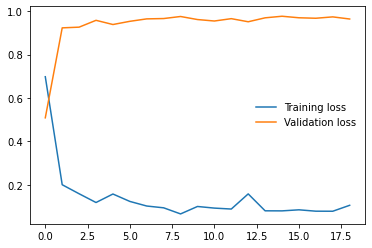

In [ ]:
# ĐỒ THỊ ĐÁNH GIÁ LOSS VÀ ACCURACY
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [33]:
# VIẾT HÀM ĐƯA GIÁ TRỊ DỰ DOÁN KHI ĐƯA ẢNH TEST VÀO 
def load_model(model,save_path):
  load_weights = torch.load(save_path)
  model.load_state_dict(load_weights)
  return model

In [34]:
class_index = ["free","busy"]
class Predictor():
  def __init__(self,class_index):
    self.clas_index = class_index

  def predict_max(self,output):
    max_id = np.argmax(output.detach().numpy())
    predict_label = self.clas_index[max_id]
    return predict_label
predictor = Predictor(class_index)

In [35]:
def predict(img):
  model = Cnn()
  model.eval()
  model = load_model(model,save_path)

  transform = ImageTransform(resize,mean,std)
  img = transform(img,phase="test")
  img = img.unsqueeze_(0)

  output = model(img)
  response = predictor.predict_max(output)

  return response


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=110x110 at 0x1D5591FCCA0>


'busy'

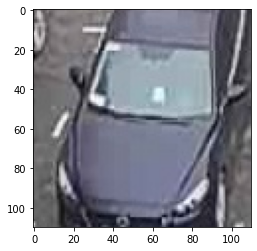

In [36]:
#TEST THỬ 1 ẢNH
Testname_free=os.listdir('datasets/test/busy')
path='datasets/test/busy/'+Testname_free[1]

img =Image.open(path)
plt.imshow(img)
print(img)
predict(img)

'free'

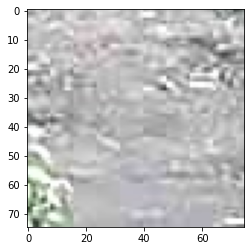

In [37]:
Testname_free=os.listdir('datasets/test/free')
path='datasets/test/free/'+Testname_free[3]

img =Image.open(path)
plt.imshow(img)
predict(img)

In [38]:
#1 VỊ TRÍ
df = pd.read_csv(r"coordition.csv")
Testname_free=os.listdir('parking')
path='parking/'+Testname_free[2]

img_show = cv2.imread(path)
img = Image.open(path)
index = 5
x = df['x'][index - 1]+35
y = df['y'][index - 1]+20
w = df['w'][index - 1] + x
h = df['h'][index - 1] + y
area = (x, y, w, h)
cropped_img = img.crop(area)
predicted = predict(cropped_img)
print(predicted)
if predicted =="busy":
  cv2.rectangle(img_show, (x, y), (w, h), (0, 0, 255), 3)
else:
  cv2.rectangle(img_show, (x ,y) ,(w , h),(0,255,0),3)
img1 = cv2.resize(img_show, dsize=None, fx=0.5, fy=0.5)
cv2.imshow("Image",img1)
cv2.waitKey(0)

busy


27

In [ ]:
#FULL VỊ TRÍ
df = pd.read_csv(r"coordition.csv")
Testname_free=os.listdir('parking')
path='parking/'+Testname_free[2]

img1 = cv2.imread(path)
img = Image.open(path)
for index in df['index']:
   x = df['x'][index - 1]+35
   y = df['y'][index - 1]+20
   w = df['w'][index - 1] + x
   h = df['h'][index - 1] + y
   area = (x, y, w, h)
   cropped_img = img.crop(area)
   predicted = predict(cropped_img)
   if predicted == "busy":
       cv2.rectangle(img1, (x, y), (w, h), (0, 0, 255), 3)
   else:
       cv2.rectangle(img1, (x, y), (w, h), (0, 255, 0), 3)
img = cv2.resize(img1, dsize=None, fx=0.5, fy=0.5)
cv2.imshow("Image",img)